# Neuroscience 490
## Lesson 5 - Firing Rates
### Content
[Section 1 - Loading and Cleaning Data](#Section1)
<br/>
[Section 2 - Spike Trains and the PSTH](#Section2)
<br/>
[Section 3 - Making Things Smooth](#Section3)
<br/><br/><br/>
In this lesson, we are going to continue our investigation of neural data. Last week we learned how to load Lab Chart files, a simple spike sorting technique for extracellular data, and how to extract AP waveforms. Today we are going to hone in on firing rates and how to extract them from raw voltage data. In focusing on firing rate, we are implicitly saying that we *don't* care about spike duration, amplitude, or shape, **only timing**. That stuff is important, and for your lab reports those characteristics ought to be investigated, however for todays lesson we are going to ignore those aspects of the data.

<a id='Section1'></a>
### Section 1 - Loading and Cleaning Data

Like always, we begin by importing the libraries that we will need. These are the same as last time, with the acception of one addition <code>scipy.ndimage</code>, which contains one particular function we will use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, ndimage
from labchart_dataset import LabChartDataset
plt.rcParams['figure.dpi'] = 75

To start our journey to extracting a firing rate, lets first load our data as a <code>LabChartDataset</code> object. The data we are dealing with today is of an extracellular recording from a cockroach leg during deflection of a sensory spine. Though the data is from an extracellular recording, it contains only one distinct neuron, and the point of todays lesson is not to do spike sorting anyway. The data was recorded at 20kHz and contains a single Lab Chart block.

In [2]:
dataset = LabChartDataset('/Users/jeremyschroeter/Desktop/School_Work/UW/Neuro301-Coding-Kit/Data/PhasicDataReal.mat')
print(dataset.sample_rate)

[[20000.]]


In [3]:
block = dataset.get_block(0)

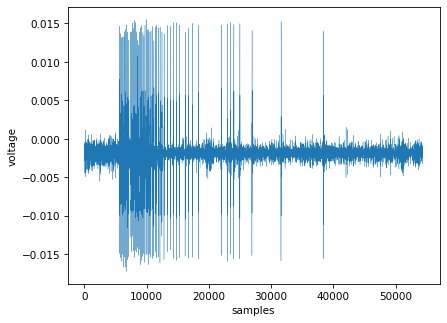

In [4]:
plt.plot(block, lw=0.3)
plt.ylabel('voltage')
plt.xlabel('samples')
plt.show()

Great! We can see very clearly the point of stimulus onset as when the flurry of spikes begins. In order to start quantifying the firing rate we need to isolate the spike times from this data. Just like last time, we can get the spike times using <code>signal.find_peaks()</code>. Recall from last class that specifying the minimum temporal distance between spike occurences was important for our data to be clean. Lets zoom in to when our spikes start occuring and see how far apart they tend to be. We'll then use that information to set a reasonable threshold for the peak finding function.

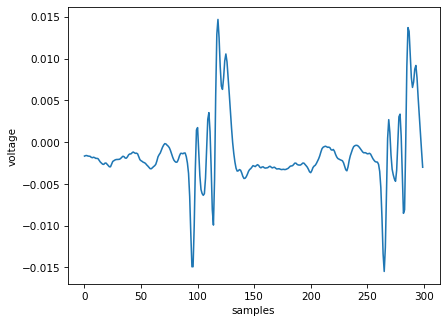

In [6]:
plt.plot(block[5500:5800])
plt.ylabel('voltage')
plt.xlabel('samples')
plt.show()

Okay so at stimulus onset our peaks are separated by roughly 150 samples. Lets set our minimum distance to 100 samples for now and work with that. Remember that if we want to obtain our data without specifying thresholds for peak height and width we can pass <code>(None, None)</code> to those parameters. Also remember that we need to invert our data for <code>find_peaks</code> to work properly.

In [11]:
peaks, properties = signal.find_peaks(-block, height=(None, None), width=(None, None), distance=100)
height, width = properties['peak_heights'], properties['widths']

Let's now use a scatter plot of height against width to see our neurons cluster.

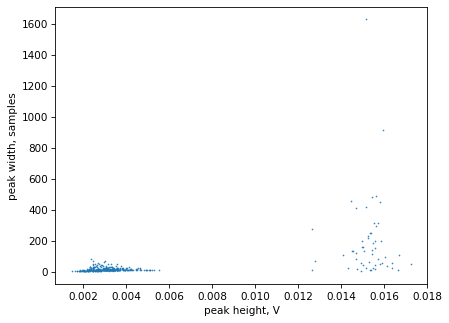

In [12]:
plt.scatter(height, width, s=0.3)
plt.xlabel('peak height, V')
plt.ylabel('peak width, samples')
plt.show()

Great! The cluster of points with peaks higher than 0.012 almost certainly correspond to our neuron. That one point with a width of 1600 samples might look problematic, but I've already investigated and seen that it is fine and does correspond to a real peak. Whenever you have outliers like that it is good to investigate it.

<a id='Section2'></a>
### Section 2 - Firing Rates, Spike Trains, and the PSTH
Now that we have the spike times, lets visualize them. To do this we can create something called a spike train. A spike train is just an array equal in length to our recording, except that it is filled with zeros everywhere *except* where there is a spike; at the index corresponding to the spike the array equals 1.

In [13]:
spike_train = np.zeros_like(block)
spike_times = peaks[height > 0.012]
spike_train[spike_times] = 1

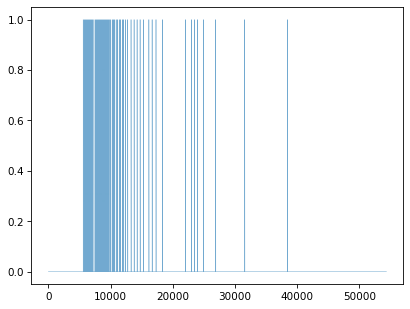

In [14]:
plt.plot(spike_train, lw=0.3)
plt.show()

Great! With the spike train we have thrown out all of the information about spike shape, and are just left with their timing. Now we can move onto obtaining the firing rate. Let's talk about what the firing rate actually is. In its simplest form, the firing rate is just the number of spikes in a certain time window. The firing rate thus has units of *spikes per second* or *Hz*. Lets continue with this definition for a moment and see if we can spot its flaws.

In [15]:
total_spikes = np.sum(spike_train)
firing_rate = total_spikes / len(spike_train)
# Our firing rate is in dimensions spikes / sample
# To convert it we can just multiply it by the sample rate
firing_rate = firing_rate * 20000
print(f'Firing rate: {firing_rate:0.4f} spikes per second')

Firing rate: 20.2392 spikes per second


### Exercise/Discusion 1
What are we missing with this definition of firing rate?

We are missing time varying properties of the firing rate! Obviously from our spike train we know that the firing rate isn't static across our recording. How can we go about estimating a *time-varying* firing rate? There are many ways to do this, but we are going to go over 3. The first method we will learn is to just use smaller bins!

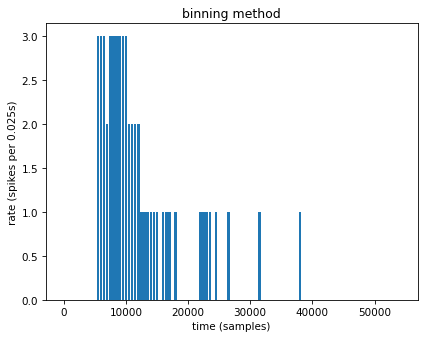

In [121]:
bin_size = 500

# Building our sums
sums = []
for i in range(0, len(spike_train), bin_size):
    bin = spike_train[i : i + bin_size]
    bin_sum = bin.sum()
    sums.append(bin_sum)

plt.bar(np.arange(len(sums)), sums)

# Building our ticks and labels
xticks_positions = range(0, len(sums), 20)
labels = []
for tick in xticks_positions:
    labels.append(tick * bin_size)

plt.xticks(ticks=xticks_positions, labels=labels)
plt.title('binning method')
plt.ylabel(f'rate (spikes per {bin_size / 20000}s)')
plt.xlabel('time (samples)')
plt.show()

### Exercise/Discussion 2
What are some potential pitfalls of this method for estimating firing rates? What happens as our bins get smaller?

If we want high temporal resolutions, our bins must be made small. But then counts are primarily zero or one. One way of dealing with this is to collect many responses to the same stimuli and to average the firing rates across those trials, just like how we have been doing ensemble averaging.
</br></br>
Another potential issue is the jaggedness of this barplot. Do we really think that the firing rate jumps from 0 to 6 spikes per second? Or do we think it is a more gradual process?
</br></br>
One way to do this is to use a *sliding* window. We will choose a size for our window and *slide* it across our spike train, counting the spikes present in our window. This will have the effect of smoothing out or firing rate because we are effectively using many more windows except now they are able to overlap.
</br></br>
We could write out this sliding window operation in a for loop, but it is actually such a common and important mathematical operation that it gets its own special name and numpy function ***convolution***

Text(0, 0.5, 'spikes per 0.05s')

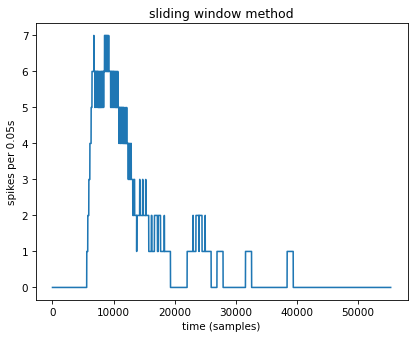

In [118]:
window_size = 1000
window = np.ones(window_size)
sliding_window_fr = np.convolve(window, spike_train)
plt.plot(sliding_window_fr)
plt.title('sliding window method')
plt.xlabel('time (samples)')
plt.ylabel(f'spikes per {window_size / 20000}s')

### Exercise/Discussion 3
What are some potential pitfalls of this method?

Perhaps the biggest problems with all of the methods we've learned so far is that they aren't smooth. Luckily we can fix this! Convolution is a very general idea. What I mean by that is there is we aren't limited to a square box with a height of 1 for a window shape, it can be any arbitrary array/math function!
</br></br>
The most common choice for estimating firing rates/smoothing is probably the Gaussian or normal curve. We actually don't have to make the Gaussian curve though. Convolution with a Gaussian is so common that it too has its own function: <code>scipy.ndimage.gaussian_filter1d</code>. We still need to decide on a width for our Gaussian however, and we can pass it to the function using the **sigma** parameter.

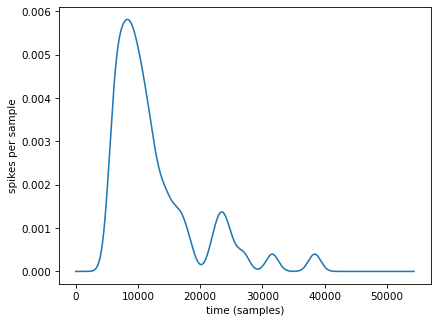

In [120]:
width = 1000
smooth_firing_rate = ndimage.gaussian_filter1d(spike_train, sigma=width)
plt.plot(smooth_firing_rate)
plt.xlabel('time (samples)')
plt.ylabel('spikes per sample')
plt.show()